In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.ground_truth_encoders.radcloud_gt_encoder import RadCloudGTEncoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.dataset_generators.rng_az_to_pc_dataset_generator import RngAzToPCDatasetGenerator

In [1]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud_original.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

NameError: name 'ConfigManager' is not defined

In [ ]:
#determine the paths to all of the datasets
dataset_groups = ["ugv_seen_dataset","ugv_unseen_dataset","ugv_rapid_movement_dataset"]

train_scenario_folders = []
test_scenario_folders = []

for group in dataset_groups:
    group_path = os.path.join(MODEL_TRAINING_DATASET_PATH,group)
    entries = sorted(os.listdir(group_path))
    for entry in entries:
        path = os.path.join(group_path,entry)
        if os.path.isdir(path):
            if 'test' in entry.lower():
                test_scenario_folders.append(path)
            else:
                train_scenario_folders.append(path)

In [ ]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

In [ ]:
#initialize the encoder and decoder
input_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=40,
    radar_fov_rad= [-0.87,0.87],
    num_az_angle_bins=64,
    power_range_dB=[60,105]
)

ground_truth_encoder = RadCloudGTEncoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],
    num_angle_bins=48,
    num_previous_frames=0
)

plotter = PlotterRngAzToPC()

In [ ]:
#plot a sample of the input/output for training
adc_cube = dataset.get_radar_data(idx=0)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)

plotter.plot_compilation(
    adc_cube=adc_cube,
    input_encoder=input_encoder,
    lidar_pc=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [ ]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_train")
dataset_generator = RngAzToPCDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="x_s",
    ground_truth_encoding_folder="y_s",
    clear_existing_data=True
)

In [ ]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

In [ ]:
#generating the testing dataset
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_test")
dataset_generator.reset(generated_dataset_path)
dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)


In [1]:
from mmwave_model_integrator.config import Config
config_path = "../configs/radcloud_single_chirp.py"
config = Config(config_path)

config.print_config()

model=dict(
    type=RadCloudUnet,
    encoder_input_channels=40,
    encoder_out_channels=(64, 128, 256),
    decoder_input_channels=(512, 256, 128),
    decoder_out_channels=64,
    output_channels=1,
    retain_dimmension=False,
    input_dimmensions=(64, 48),
),
trainer=dict(
    type=_BaseTorchTrainer,
    model=dict(
        type=RadCloudUnet,
        encoder_input_channels=40,
        encoder_out_channels=(64, 128, 256),
        decoder_input_channels=(512, 256, 128),
        decoder_out_channels=64,
        output_channels=1,
        retain_dimmension=False,
        input_dimmensions=(64, 48),
    ),
    optimizer=dict(
        type=Adam,
        lr=0.001,
    ),
    dataset=dict(
        type=_BaseTorchDataset,
    ),
    dataset_path=/home/david/Downloads/generated_datasets/RadCloud_train,
    input_directory=x_s,
    output_directory=y_s,
    val_split=0.15,
    working_dir=working_dir,
    save_name=RadCloud_40_chirps_10e,
    input_transforms=[{'type': 'RandomRadarNoise', 

In [5]:
import mmwave_model_integrator.torch_training.trainers as trainers

trainer_config = config.trainer
trainer_class = getattr(trainers,trainer_config.pop('type'))
trainer = trainer_class(**trainer_config)


ModelTrainer: 70787 train, 12492 val samples loaded
DatasetGenerator._check_for_directory: found directory working_dir


ModelTrainer.train: training the network...


 10%|█         | 1/10 [00:41<06:10, 41.18s/it]

EPOCH: 1/10
	 Train loss: 0.2652760148048401, Val loss:0.1980622261762619


 20%|██        | 2/10 [01:21<05:25, 40.73s/it]

EPOCH: 2/10
	 Train loss: 0.17964041233062744, Val loss:0.18142670392990112


 30%|███       | 3/10 [02:02<04:44, 40.67s/it]

EPOCH: 3/10
	 Train loss: 0.1601467728614807, Val loss:0.15719282627105713


 40%|████      | 4/10 [02:42<04:04, 40.70s/it]

EPOCH: 4/10
	 Train loss: 0.14391329884529114, Val loss:0.14380089938640594


 50%|█████     | 5/10 [03:23<03:23, 40.77s/it]

EPOCH: 5/10
	 Train loss: 0.12878908216953278, Val loss:0.13553191721439362


 60%|██████    | 6/10 [04:04<02:42, 40.59s/it]

EPOCH: 6/10
	 Train loss: 0.11560060828924179, Val loss:0.12233396619558334


 70%|███████   | 7/10 [04:44<02:01, 40.44s/it]

EPOCH: 7/10
	 Train loss: 0.10453230142593384, Val loss:0.11377058923244476


 80%|████████  | 8/10 [05:24<01:20, 40.37s/it]

EPOCH: 8/10
	 Train loss: 0.09544961899518967, Val loss:0.108327716588974


 90%|█████████ | 9/10 [06:05<00:40, 40.47s/it]

EPOCH: 9/10
	 Train loss: 0.08770783990621567, Val loss:0.10226133465766907


100%|██████████| 10/10 [06:45<00:00, 40.53s/it]

EPOCH: 10/10
	 Train loss: 0.08169714361429214, Val loss:0.09784146398305893
ModelTrainer.train: total training time 405.30


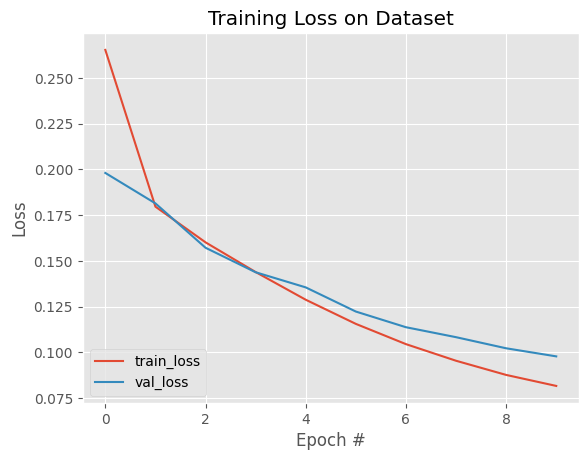

In [6]:
#train the model
trainer.train_model()